# Exercise: Assessing a logistic regression model

In the previous exercise, we fit a simple logistic regression model to predict the chance of an avalanche. This time, we'll create the same model and take a deeper look at how to best understand the mistakes that it makes.

## Data visualization

Let's remind ourselves of our data. Remember we're planning to train a model that can predict avalanches based on the number of weak layers of snow.

   Unnamed: 0  avalanche  no_visitors  surface_hoar  fresh_thickness  wind  \
0           0          0            4      3.900508         8.715485     6   
1           1          0            9      1.477586         6.801417    30   
2           2          1            3      3.236594         5.632457     8   
3           3          0            0      3.244283         9.348871    12   
4           4          1            2      5.196741         3.782315     4   

   weak_layers  tracked_out  
0            9            0  
1            0            0  
2            8            1  
3           10            0  
4            9            1  


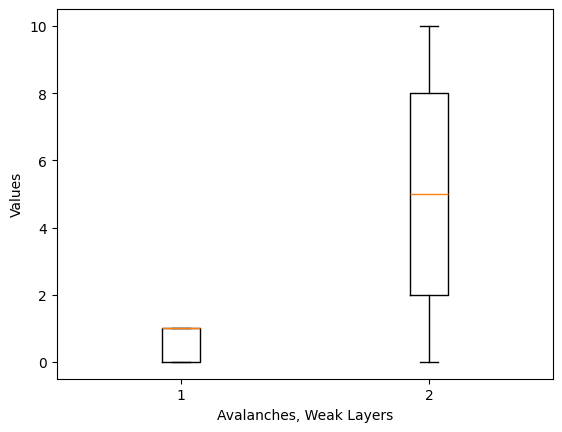

In [2]:
import pandas
#!pip install statsmodels
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
#!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/avalanche.csv
import matplotlib.pyplot as plt

#Import the data from the .csv file
url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/avalanche.csv"
dataset = pandas.read_csv(url, delimiter="\t")

#Let's have a look at the data and the relationship we're going to model
print(dataset.head())

plt.boxplot([dataset["avalanche"], dataset["weak_layers"]])

plt.xlabel("Avalanches, Weak Layers")
plt.ylabel("Values")

plt.show()

It seems that avalanches are associated with having more weak layers of snow. That said, some days many weak layers have been recorded, but no avalanche occurred. This means our model will have difficulty being extremely accurate using only this feature. Let's continue, though, and come back to this in a future exercise.  

Before we begin, we need to split our dataset into training and test sets. We'll train on the _training_ set, and test on (you guessed it) the _test_ set.

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset in an 75/25 train/test ratio. 
train, test = train_test_split(dataset, test_size=0.25, random_state=10)

print("Train size:", train.shape[0])
print("Test size:", test.shape[0])

Train size: 821
Test size: 274


## Fitting a model

Let's fit a simple logistic regression model using *log-loss* as a cost function. This is a very standard way to fit a classification model; so standard, in fact, that we don't need to specify it at all.

In [4]:
import statsmodels.formula.api as smf

# Perform logistic regression.
model = smf.logit("avalanche ~ weak_layers", train).fit()

print("Model trained")

Optimization terminated successfully.
         Current function value: 0.616312
         Iterations 5
Model trained


## Assessing the model with summary information

If we use `statsmodels`, we can get a detailed summary about the model by simply calling `summary()`

In [5]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      819
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Sep 2025   Pseudo R-squ.:                  0.1018
Time:                        16:33:56   Log-Likelihood:                -505.99
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 9.269e-27
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0656      0.148     -7.207      0.000      -1.355      -0.776
weak_layers     0.2643      0.026      9.985      0.000       0.212       0.316
===============================================================================
"""

This summary provides some detailed information. 

Two useful pieces of information are in the bottom row. The coef for `weak_layers` is positive, which means that as `weak_layers` increases, so does the probability of an avalanche. The `P` value column is less than 0.05, which means the model is confident that `weak_layers` is a useful predictor of avalanches. 

The rest of this table, however, is difficult to understand for beginners, and so it's not clear how well our model is working. Let's try another way. 

## Assessing model visually

Sometimes, but not always, we can visually assess a logistic regression mode. Let's plot our model against the actual data in the test dataset.

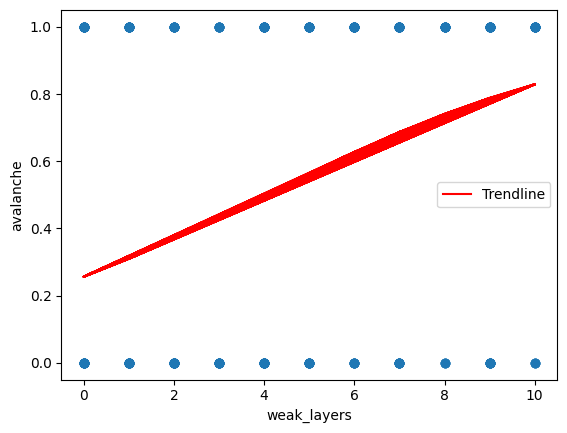

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def predict(weak_layers):
    return model.predict(pd.DataFrame({"weak_layers": weak_layers}))

plt.scatter(test['weak_layers'], test['avalanche'])

trendline_values = predict(test['weak_layers'])
plt.plot(test['weak_layers'], trendline_values, color='red', label="Trendline")

plt.xlabel("weak_layers")
plt.ylabel("avalanche")
plt.legend()

plt.show()

It's hard to see the s-shape of the trendline, because the number of weak layers of snow, and the likelihood of an avalanche, are only weakly related. If we zoom out, we can get a slightly better view:

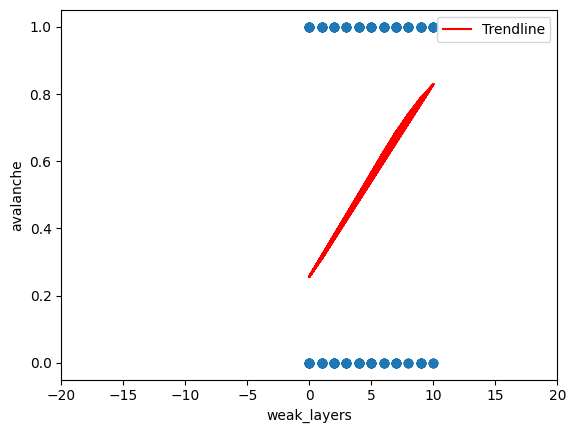

In [7]:

def predict(weak_layers):
    return model.predict(pd.DataFrame({"weak_layers": weak_layers}))


plt.scatter(test['weak_layers'], test['avalanche'])
trendline_values = predict(test['weak_layers'])
plt.plot(test['weak_layers'], trendline_values, color='red', label="Trendline")
plt.xlim(-20, 20)
plt.xlabel("weak_layers")
plt.ylabel("avalanche")
plt.legend()

plt.show()

Checking the earlier graph, we can see that our model will predict an avalanche when the number of weak layers of snow is greater than 5. We can tell this because the value of the line is `0.5` at `x=5` (remember that in the previous unit we defined a *classifier threshold*, so that probabilities over `0.5` would be classified as `True`).

How this relates with points is hard to tell; the points overlap, and so it's difficult to see how many points are at 0 or at 1. How else can we assess the model?

## Assess with cost function

Let's assess our model with a log-loss cost function.


In [8]:
from sklearn.metrics import log_loss

# Make predictions from the test set
predictions = model.predict(test)

# Calculate log loss
print("Log loss", log_loss(test.avalanche, predictions))

Log loss 0.6803588691541006


0.68; what does that mean? This could be useful to compare two different models, but it's hard to get a grasp on exactly what this means for real-world performance. 

## Assess accuracy

Let's instead assess _accuracy_. Accuracy refers to the _proportion of predictions the model got correct_, after predictions are converted from probabilities to `avalanche` or `no-avalanche`.

The first thing to do is convert probabilities to hard predictions:

In [9]:
import numpy

# Print a few predictions before we convert them to categories
print(f"First three predictions (probabilities): {predictions.iloc[0]}, {predictions.iloc[1]}, {predictions.iloc[2]}")

# convert to absolute values
avalanche_predicted = predictions >= 0.5

# Print a few predictions converted into categories
print(f"First three predictions (categories): {avalanche_predicted.iloc[0]}, {avalanche_predicted.iloc[1]}, {avalanche_predicted.iloc[2]}")

First three predictions (probabilities): 0.788017694282122, 0.6866335148335762, 0.5636126304803127
First three predictions (categories): True, True, True


Now we can calculate accuracy:

In [10]:
# Calculate what proportion were predicted correctly
guess_was_correct = test.avalanche == avalanche_predicted
accuracy = numpy.average(guess_was_correct)

# Print the accuracy
print("Accuracy for whole test dataset:", accuracy)

Accuracy for whole test dataset: 0.6167883211678832


It looks like it's predicting the correct answer 61% of the time. This is helpful information. What kind of mistakes is it making, though? Let's take a look at whether it is guessing avalanche when there are none (false positives), or failing to guess 'avalanche' when one actually occurs (false negative):

In [11]:
# False Negative: calculate how often it guessed no avalanche when one actually occurred
false_negative = numpy.average(numpy.logical_not(guess_was_correct) & test.avalanche)

# False positive: calculate how often it guessed avalanche, when none actually happened
false_positive = numpy.average(numpy.logical_not(guess_was_correct) & numpy.logical_not(test.avalanche))


print(f"Incorrectly predicted an avalanche {false_positive * 100}% of the time")
print(f"Failed to predict avalanches {false_negative * 100}% of the time")

Incorrectly predicted an avalanche 17.153284671532848% of the time
Failed to predict avalanches 21.16788321167883% of the time


I think we can agree that's a lot more understandable than reading the cost function or the graph!

## Summary

We've walked through different ways to assess a logistic regression model. We've seen that detailed summaries can provide rich information, but this can be difficult to digest. Metrics for these kinds of models also aren't necessarily intuitive or detailed enough to understand the model. With a little extra work, we can look at actual predictions versus actual outcomes and get an intuition for how the model might work in the real world.